In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functions_used import calculate_IV, plot_by_woe

In [2]:
warnings.filterwarnings('ignore') # to supress warnings

In [3]:
sns.set()

# loading training data.
data_in_use = pd.read_csv('dataset/train_input.csv') # Loading updated data.
output_data = pd.read_csv('dataset/train_output.csv') # Loading updated data.

In [4]:
### Convert the cell above into markdown, before running this cell.

### loading testing data.
data_in_use = pd.read_csv('dataset/test_input.csv') # Loading updated data.
output_data = pd.read_csv('dataset/test_output.csv') # Loading updated data.

## **Now, we will work with some discrete (Categorical) varaibles.**

### It’s important to understand that categorical variables, such as gender (e.g., male or female), cannot be used directly in most statistical models. To include them in modeling, we convert these categories into numerical format using **dummy variables (one hot encoding)**. For example, we might represent "male" as `1` and "female" as `0`.

---

### How dummy variables work:
- When encoding a categorical variable with **K** categories, we create **K - 1** dummy variables (new columns).
- Each dummy variable (new column) represents one category with values 0 or 1.
- For each record, **only one dummy variable can be 1**, corresponding to the category that record belongs to.
- All other dummy variables for that record will be 0.
- The **original categorical column is removed** after creating these dummy variables.


### Example with `Color` categories (Red, Blue, Green):

| Color | Is_Red | Is_Blue | Is_Green | 
|-------|--------|---------| ---------|
| Red   | 1      | 0       | 0        | 
| Blue  | 0      | 1       | 0        |
| Green | 0      | 0       | 1        |


- So **only one dummy variable is 1** per record. It is important to understand, we created 3 (K=3) new columns, but we removed 1 original column. So, by creating **K - 1** dummy variables, we fully represent the original categorical variable’s information without redundancy.

---

If you ever see both dummies equal to 1 in the same row, it means there is a mistake in encoding or data. Each row can belong to only **one category**.

---

### Dummy Variable Trap in Logistic Regression

When we convert a categorical variable into multiple dummy (0/1) variables using techniques like `pd.get_dummies()`, **including all dummy variables in the model can lead to perfect multicollinearity** — a situation where one variable can be perfectly predicted from the others.  
This is called the **Dummy Variable Trap**.

To avoid it, we **drop one dummy variable** and treat it as the **reference category**.  
The coefficients of the remaining dummy variables are then interpreted **relative to this reference category**.

**Example:**
If `Color` has three categories — Red, Blue, Green — and we choose **Green** as the reference:

| Red | Blue |
|-----|------|
| 1   | 0    |
| 0   | 1    |
| 0   | 0    |

- **Green** is the reference (both `Red=0` and `Blue=0`).
- The coefficient for `Red` shows the change in log-odds compared to Green.
- The coefficient for `Blue` shows the change in log-odds compared to Green.

### How dummy variables are created:

- Pandas have a built-in function pd.get_dummies(dataset['column_name']) that create dummy variables for agiven categorical variables.


> In `pd.get_dummies()`, you can avoid the trap by using:
> ```python
> pd.get_dummies(df['column_name'], drop_first=True)
> ```

---

### Discrete variables we'll work with are,

> grade
> 
> sub_grade
> 
> home_ownership
> 
> verification_status
> 
> loan_status
> 
> purpose
> 
> addr_state
> 
> initial_list_status
> 
> term_int (we preprocessed this variable earlier)
> 
> emp_length_int (we preprocessed this variable earlier)

In [5]:
# months_since_issue_date:- Total of 139 distinct categories.

variable_list = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status',
                'purpose', 'addr_state', 'initial_list_status', 'term_int', 'emp_length_int',]

for i in variable_list:
    print(f"{i}: Total of {len(data_in_use[i].unique())} distinct categories.", "\n")

grade: Total of 7 distinct categories. 

sub_grade: Total of 35 distinct categories. 

home_ownership: Total of 6 distinct categories. 

verification_status: Total of 3 distinct categories. 

loan_status: Total of 9 distinct categories. 

purpose: Total of 14 distinct categories. 

addr_state: Total of 51 distinct categories. 

initial_list_status: Total of 2 distinct categories. 

term_int: Total of 2 distinct categories. 

emp_length_int: Total of 11 distinct categories. 



In [6]:
# Using this function we can actually create dummy variables
pd.get_dummies(data_in_use['grade'], prefix = 'grade', prefix_sep = ':')[:10]

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,False,False,False,False,True,False,False
1,False,False,True,False,False,False,False
2,False,False,False,False,True,False,False
3,False,True,False,False,False,False,False
4,False,True,False,False,False,False,False
5,False,False,False,False,False,True,False
6,False,False,False,False,True,False,False
7,False,True,False,False,False,False,False
8,False,False,False,True,False,False,False
9,False,False,True,False,False,False,False


In [7]:
### Now, we'll use the same function to create dummy variables for all categorical variables mentioned above.

for i in variable_list:
    categorical_variables = [pd.get_dummies(data_in_use[i], prefix = i, prefix_sep = ':') for i in variable_list]


dataframe_from_categorical_variables = pd.concat(categorical_variables, axis = 1)

 # axis = 1 (concat by columns), axis = 0 (concat by row)
data_in_use = pd.concat([data_in_use, dataframe_from_categorical_variables], axis = 1)

dataframe_from_categorical_variables[:10]

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,emp_length_int:1,emp_length_int:2,emp_length_int:3,emp_length_int:4,emp_length_int:5,emp_length_int:6,emp_length_int:7,emp_length_int:8,emp_length_int:9,emp_length_int:10
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
iv_per_var_dis = {}

for var in variable_list:
    df_woe, iv_grade = calculate_IV(data_in_use, output_data, var)
    iv_per_var_dis[var] = [iv_grade, df_woe]

Information Value (IV) for variable grade: 0.4755
Information Value (IV) for variable sub_grade: 0.5101
Information Value (IV) for variable home_ownership: 0.0244
Information Value (IV) for variable verification_status: 0.0864
Information Value (IV) for variable loan_status: 45.0200
Information Value (IV) for variable purpose: 0.0231
Information Value (IV) for variable addr_state: 0.0166
Information Value (IV) for variable initial_list_status: 0.0374
Information Value (IV) for variable term_int: 0.0631
Information Value (IV) for variable emp_length_int: 0.0044


In [9]:
iv_per_var_dis["grade"][1]

,grade,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
6,G,2471,0.005465,1513.0,958.0,0.003828,0.016846,0.612303,-1.481804,0.019290
5,F,8293,0.018342,5269.0,3024.0,0.013330,0.053175,0.635355,-1.383546,0.055127
4,E,27127,0.059998,19624.0,7503.0,0.049648,0.131935,0.723412,-0.977356,0.080424
3,D,65083,0.143946,52224.0,12859.0,0.132124,0.226116,0.802422,-0.537308,0.050503
2,C,130389,0.288386,112091.0,18298.0,0.283584,0.321757,0.859666,-0.126287,0.004821
1,B,132379,0.292787,121184.0,11195.0,0.306589,0.196856,0.915432,0.443037,0.048616
0,A,86392,0.191076,83360.0,3032.0,0.210896,0.053316,0.964904,1.375140,0.216696


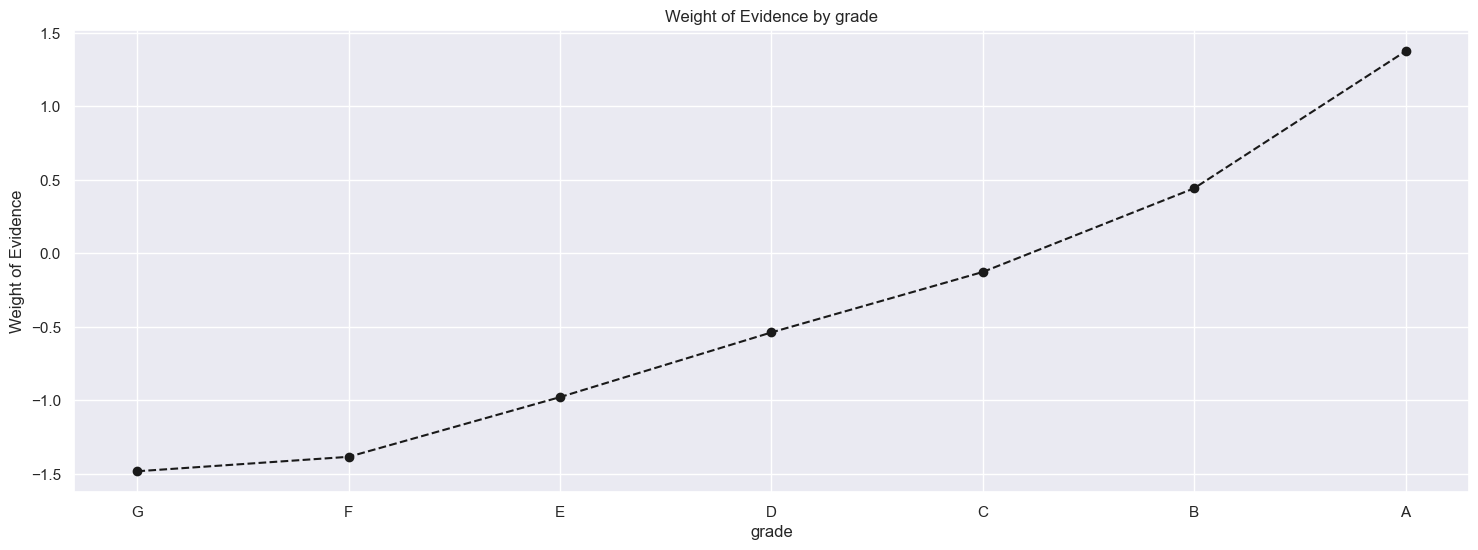

In [10]:
plot_by_woe(iv_per_var_dis["grade"][1])

### 🧠 **Grade:-Interpretation from Weight of Evidence (WoE)**

From the WoE plot, it is evident that the **probability of default is highest for grade G** and **lowest for grade A**, with a generally decreasing trend in default risk from **G to A**.

To incorporate the `grade` variable into our logistic regression model:

- We convert `grade` into **dummy variables**, as it is a categorical variable.
- Each grade represents a meaningful shift in default risk, so all categories should be included as separate indicators.
- We choose **grade G** as the **reference category** for these dummy variables, allowing us to interpret the coefficients of other grades relative to the highest-risk group.

This approach ensures that the model captures the directional risk difference across grades while maintaining interpretability.


In [11]:
iv_per_var_dis["home_ownership"][1]

,home_ownership,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
3,OTHER,45,0.000100,37.0,8.0,0.000094,0.000141,0.822222,-0.407329,0.000019
5,RENT,179161,0.396256,153066.0,26095.0,0.387249,0.458862,0.854349,-0.169681,0.012151
4,OWN,50665,0.112057,44176.0,6489.0,0.111763,0.114104,0.871923,-0.020733,0.000049
1,MORTGAGE,222064,0.491146,197798.0,24266.0,0.500419,0.426700,0.890725,0.159364,0.011748
0,ANY,193,0.000427,182.0,11.0,0.000460,0.000193,0.943005,0.867305,0.000232
2,NONE,6,0.000013,6.0,0.0,0.000015,0.000000,1.000000,11.930305,0.000181


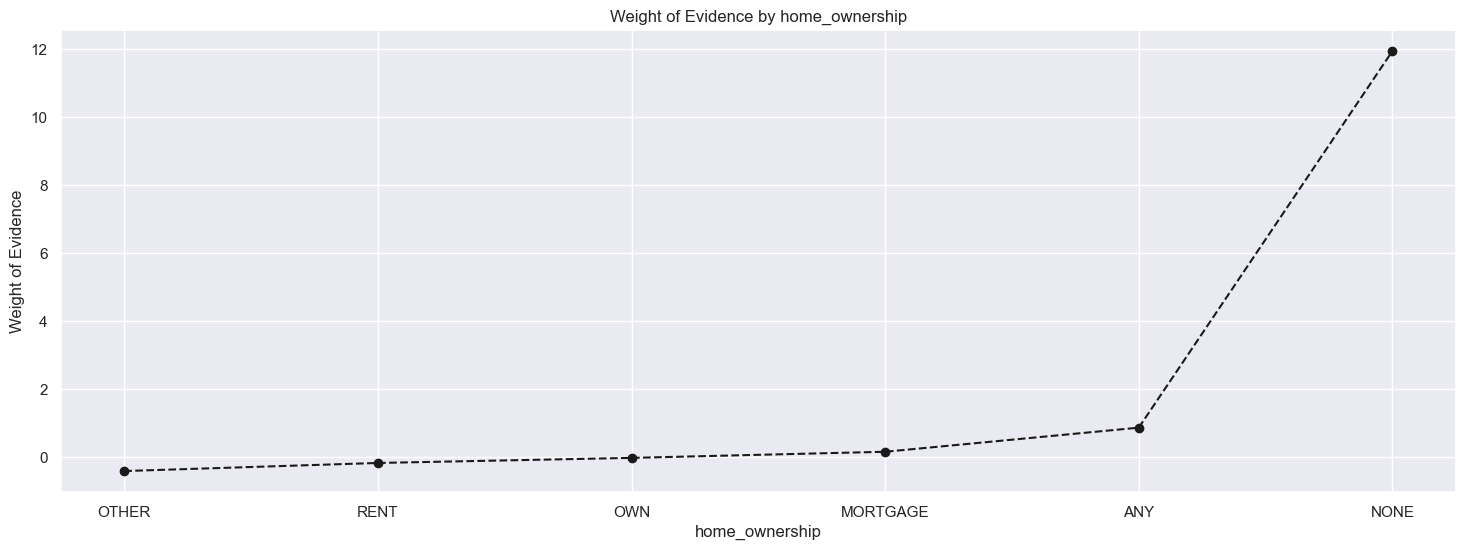

In [12]:
plot_by_woe(iv_per_var_dis["home_ownership"][1])

In [13]:
data_in_use['home_ownership:Rent_Any_None_Other'] = sum([data_in_use['home_ownership:RENT'],
                                                        data_in_use['home_ownership:ANY'],
                                                        data_in_use['home_ownership:NONE'],
                                                        data_in_use['home_ownership:OTHER']])

###  🏠 **home_ownership:- Interpretation from Weight of Evidence (WoE)**

The `home_ownership` variable contains six categories: `MORTGAGE`, `OWN`, `RENT`, `ANY`, `OTHER`, and `NONE`.

Based on the WoE and IV analysis:

- The **majority of observations** fall under `MORTGAGE` (49%) and `RENT` (39.6%), which show **moderate and distinct WoE values**.
- `OWN` also has a meaningful share (11%) and a near-neutral WoE, suggesting it's similar in risk to the overall population.
- Categories like `OTHER`, `NONE`, and `ANY` have **extremely low representation** (less than 0.05% each) and unstable or extreme WoE values due to small sample sizes:
  - `ANY` has a very **high WoE (+0.69)**, suggesting lower default rates, but this could be misleading due to few observations.
  - `OTHER` and `NONE` show **negative WoE values**, indicating higher default likelihood, but again, they are too sparse to be modeled reliably as separate levels.

#### 🛠️ Modeling Decision:

To improve model stability and avoid overfitting to rare categories:

- **We merge the low-frequency categories (`OTHER`, `NONE`, and `ANY`) into `RENT`**, the most similar and largest renter-type category.
- Note:- Although the `ANY` category has a high WoE (indicating very low default risk), it accounts for less than 0.05% of the dataset. Given this extremely low representation, keeping it as a separate category could lead to model instability or overfitting. To ensure reliable estimation and simplify the model, we merge `ANY` with `RENT`, the largest and most similar renter-type group. This merging is statistically safe given the negligible size of the `ANY` category and ensures that the logistic regression model remains robust.

#### 📈 Updated Categories:
- `MORTGAGE`
- `OWN`
- `RENT` (merged with `OTHER`, `NONE`, `ANY`)

This recoding ensures better generalization in the logistic regression model while maintaining WoE-based differentiation among borrower groups.

In [14]:
iv_per_var_dis["sub_grade"][1]

,sub_grade,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
33,G4,345,0.000763,196.0,149.0,0.000496,0.002620,0.568116,-1.664638,0.003536
31,G2,556,0.001230,325.0,231.0,0.000822,0.004062,0.584532,-1.597398,0.005175
34,G5,323,0.000714,189.0,134.0,0.000478,0.002356,0.585139,-1.594899,0.002995
32,G3,400,0.000885,241.0,159.0,0.000610,0.002796,0.602500,-1.522913,0.003329
28,F4,1163,0.002572,705.0,458.0,0.001784,0.008054,0.606191,-1.507477,0.009452
29,F5,1016,0.002247,619.0,397.0,0.001566,0.006981,0.609252,-1.494637,0.008093
26,F2,1778,0.003932,1123.0,655.0,0.002841,0.011518,0.631609,-1.399682,0.012144
27,F3,1631,0.003607,1031.0,600.0,0.002608,0.010551,0.632128,-1.397451,0.011099
25,F1,2705,0.005983,1791.0,914.0,0.004531,0.016072,0.662107,-1.266107,0.014612
30,G1,847,0.001873,562.0,285.0,0.001422,0.005012,0.663518,-1.259793,0.004522


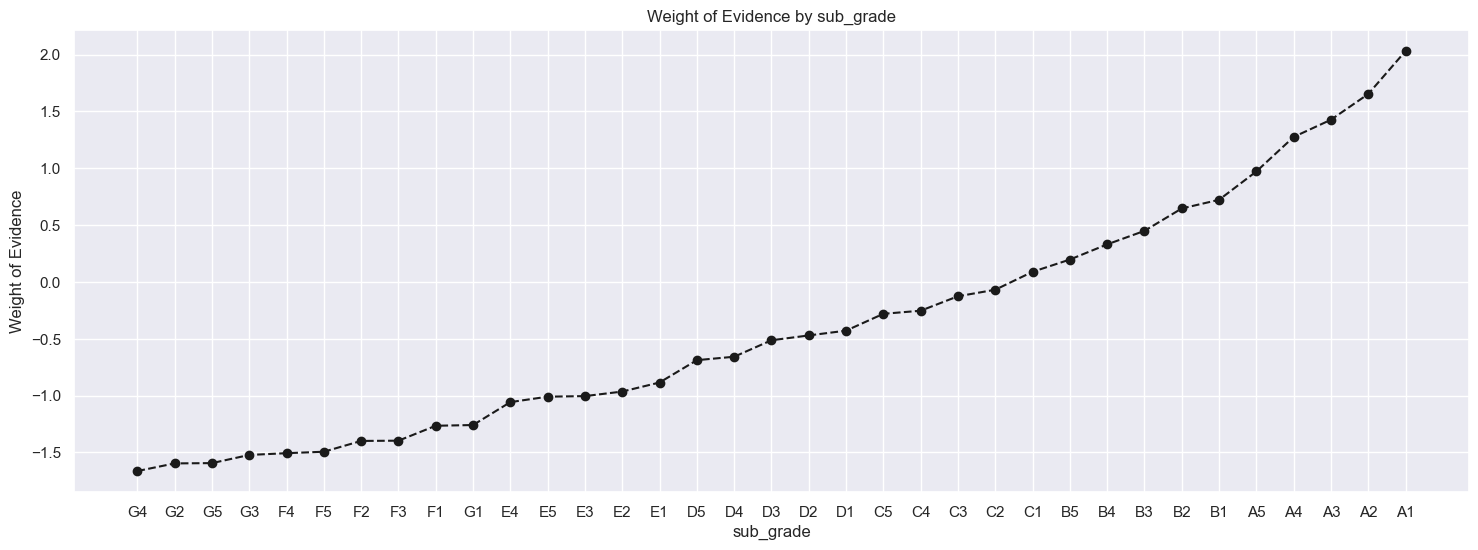

In [15]:
plot_by_woe(iv_per_var_dis["sub_grade"][1]) 

### Note:
As the name suggests, **subgrade** further divides each **grade** into smaller subcategories (e.g., A1–A5, B1–B5, etc.). From the WoE plot, it is evident that **the probability of default (PD) decreases consistently** as we move from lower subgrades (e.g., G5) to higher ones (e.g., A1), following the same trend as the main grade variable.

There are **minor variations** within some subgrades of **F and G**, but they are **not significant enough** to provide additional predictive power beyond what is already captured by the **grade** variable.

Therefore, we **do not include subgrade** in the model, as its information is already accounted for by **grade**.

---

In [16]:
""" addr_state represents the home state of the borrower in USA. In total, we have 51 distinct 
    categories (50 for us states and 1 for district of columbia)."""

iv_per_var_dis["addr_state"][1]

,addr_state,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
1,AL,5371,0.011879,4547.0,824.0,0.011504,0.014489,0.846584,-0.230754,0.000689
32,NM,2387,0.005279,2032.0,355.0,0.005141,0.006242,0.851278,-0.194148,0.000214
33,NV,6537,0.014458,5577.0,960.0,0.014110,0.016881,0.853144,-0.179333,0.000497
2,AR,3420,0.007564,2918.0,502.0,0.007382,0.008827,0.853216,-0.178752,0.000258
41,SD,899,0.001988,771.0,128.0,0.001951,0.002251,0.857620,-0.143148,0.000043
0,AK,1070,0.002367,918.0,152.0,0.002322,0.002673,0.857944,-0.140489,0.000049
18,LA,5150,0.011390,4421.0,729.0,0.011185,0.012819,0.858447,-0.136359,0.000223
24,MO,7170,0.015858,6160.0,1010.0,0.015584,0.017760,0.859135,-0.130680,0.000284
36,OK,4065,0.008991,3501.0,564.0,0.008857,0.009918,0.861255,-0.113056,0.000120
34,NY,37460,0.082852,32280.0,5180.0,0.081667,0.091087,0.861719,-0.109163,0.001028


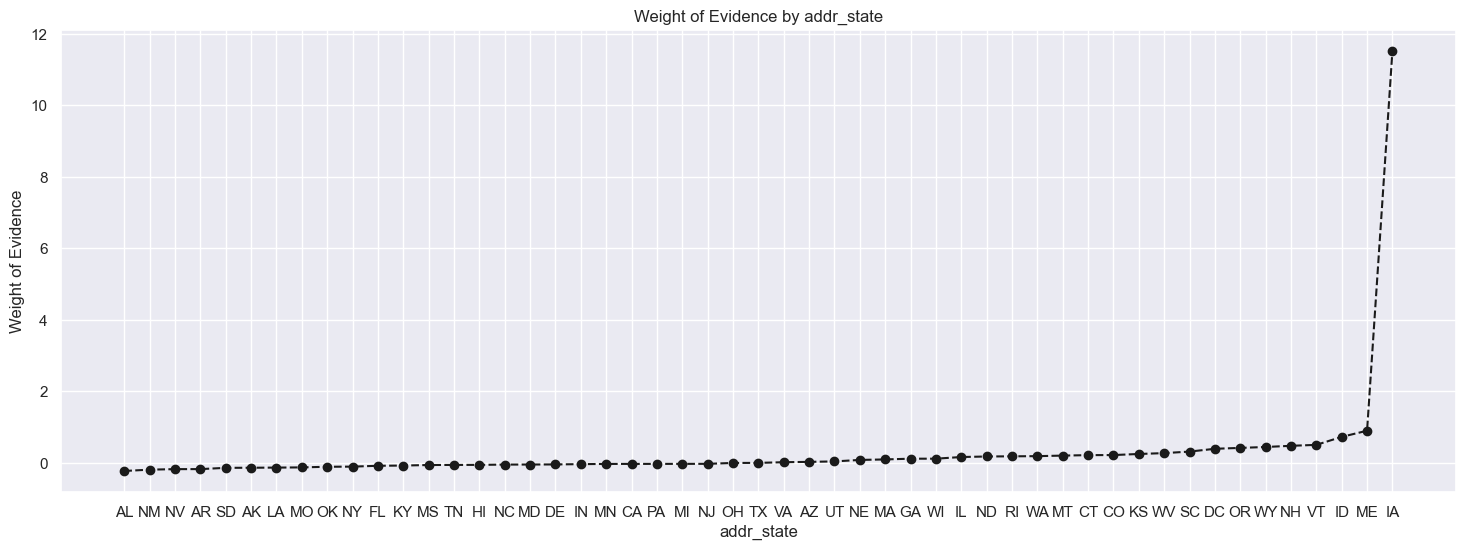

In [17]:
plot_by_woe(iv_per_var_dis["addr_state"][1])

### From the Weight of Evidence plot, it is evident that IA (Iowa) has the lowest WoE, significantly below that of other states. This is beacsue there are only 10 records from the state of IA and it is not worth to have it as a separate category, therefore we decided to merge it with the records of AL the second lowest weight of evidence.

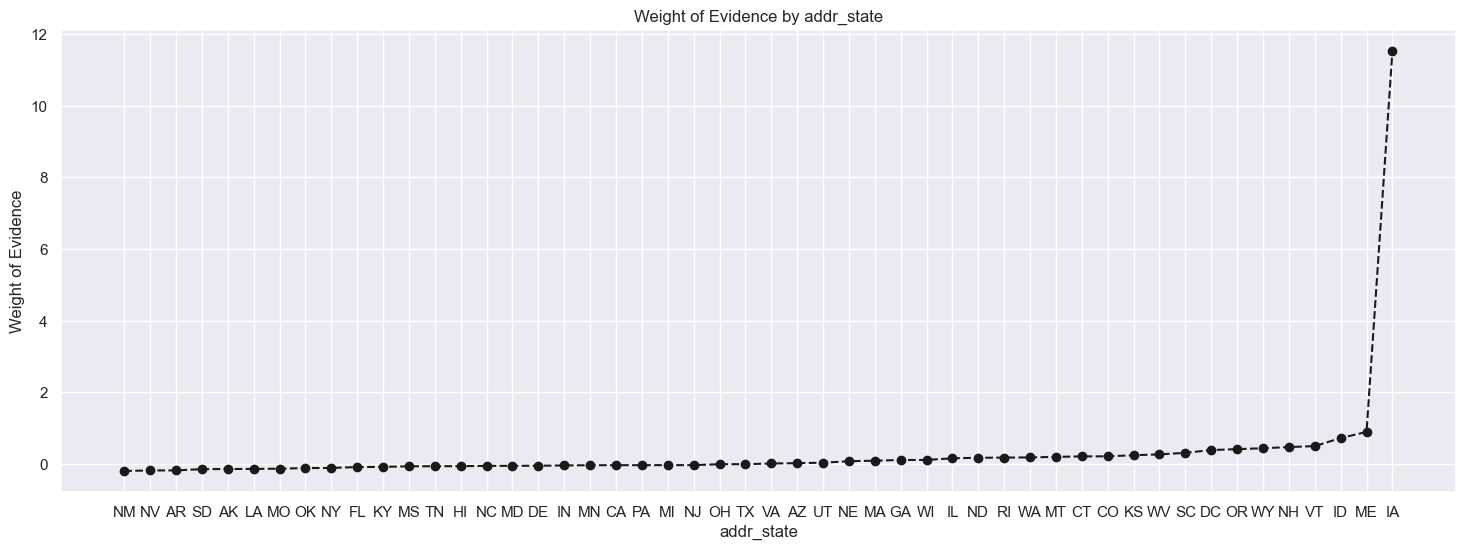

In [18]:
plot_by_woe(iv_per_var_dis["addr_state"][1].iloc[1:]) 

### In the plot above, we excluded IA due to its extremely small sample size. From the WoE plot, it is evident that **AL, MS, AR, OK, LA, and NV** have similarly low Weight of Evidence values, indicating comparable default risk levels. Given this similarity, it is reasonable to **merge these states into a single category** to simplify the model without losing meaningful predictive information.

### Therefore, Based on the Weight of Evidence analysis, we observed that AL, MS, AR, OK, LA, and NV all exhibit similarly low WoE values (approximately –0.13 to –0.22), indicating comparable default risk behavior.

Given:
- The extremely low sample size for IA,
- The statistical similarity among the others,
- And the goal of reducing model complexity,

We will group these states into a single category, to ensurs model stability without sacrificing discriminatory power.

In [19]:
# Analysing the WOE of other states, with aim of binding categories.
iv_per_var_dis["addr_state"][1][7:] 

,addr_state,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
24,MO,7170,0.015858,6160.0,1010.0,0.015584,0.017760,0.859135,-0.130680,0.000284
36,OK,4065,0.008991,3501.0,564.0,0.008857,0.009918,0.861255,-0.113056,0.000120
34,NY,37460,0.082852,32280.0,5180.0,0.081667,0.091087,0.861719,-0.109163,0.001028
9,FL,32127,0.071056,27774.0,4353.0,0.070267,0.076544,0.864506,-0.085571,0.000537
17,KY,4379,0.009685,3789.0,590.0,0.009586,0.010375,0.865266,-0.079071,0.000062
25,MS,2481,0.005487,2151.0,330.0,0.005442,0.005803,0.866989,-0.064211,0.000023
42,TN,6947,0.015365,6025.0,922.0,0.015243,0.016213,0.867281,-0.061679,0.000060
11,HI,2158,0.004773,1872.0,286.0,0.004736,0.005029,0.867470,-0.060035,0.000018
27,NC,12589,0.027844,10932.0,1657.0,0.027657,0.029137,0.868377,-0.052121,0.000077
20,MD,10941,0.024199,9503.0,1438.0,0.024042,0.025286,0.868568,-0.050452,0.000063


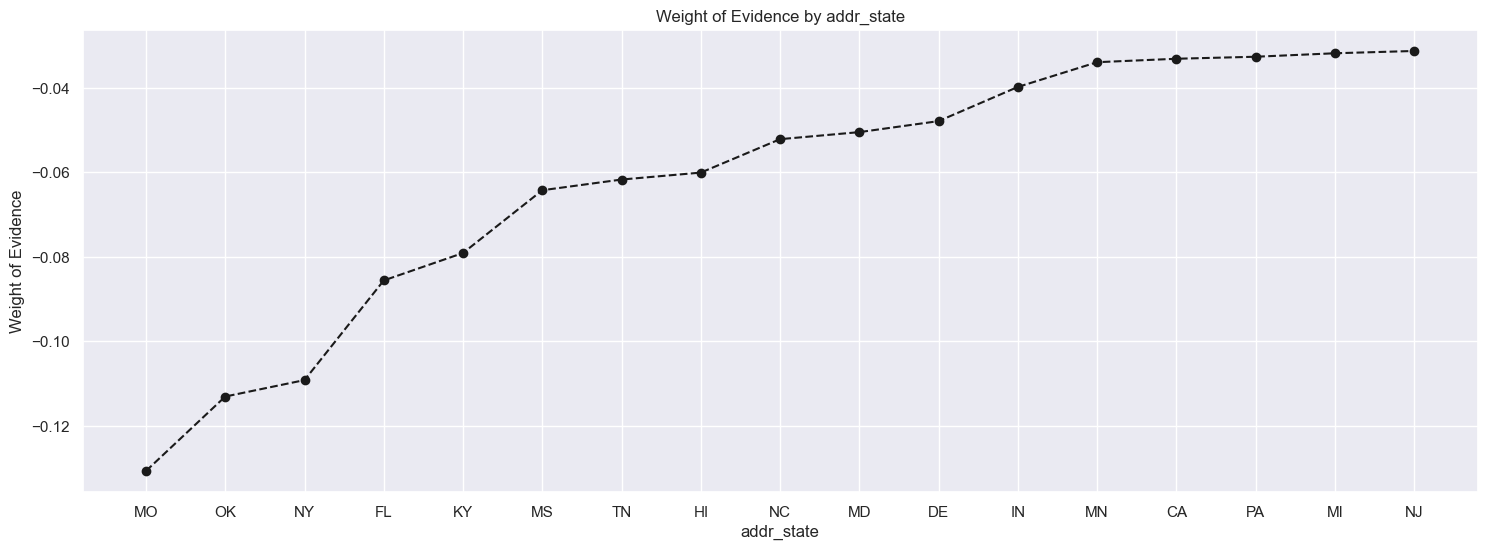

In [20]:
plot_by_woe(iv_per_var_dis["addr_state"][1][7:-27]) 

### State-Level Grouping Based on Weight of Evidence (WoE)

From the WoE table presented above, **New York (NY), Florida (FL), California (CA), and Texas (TX)** each have more than 100,000 observations. Due to their large sample sizes and potential state-specific risk patterns, these states are retained as **individual categories** in the model.

For the remaining states, those with **similar WoE values** and **smaller sample sizes** are grouped to reduce dimensionality, simplify the model, and mitigate overfitting risks associated with sparse data.

- **Maine (ME)** has a significantly higher WoE (0.76) and a sufficient number of observations (~4,000), warranting its treatment as a separate category. Its distinct risk profile suggests it would not benefit from grouping.

- **Idaho (ID)** and **Vermont (VT)** have nearly identical WoE values (0.47 and 0.49, respectively) and comparable sample sizes. These are grouped into a new category to streamline the model without losing predictive accuracy.

- **Kansas (KS), Washington (WA), Connecticut (CT), South Carolina (SC), Colorado (CO),** and **North Dakota (ND)** all have WoE values in the 0.21–0.27 range. Despite KS being at the lower end (0.208), the difference is minor. Grouping these states reflects their similar risk characteristics while keeping the model concise.

- **Georgia (GA), Wyoming (WY), Rhode Island (RI), Montana (MT),** and **Illinois (IL)** share moderate WoE values between 0.11 and 0.17. Despite variation in sample sizes, their risk levels are aligned, supporting their inclusion in a single category.

- **Minnesota (MN), Nebraska (NE),** and **Ohio (OH)** have WoE values within a narrow band, justifying their grouping based on similar risk patterns.

- **Tennessee (TN), Michigan (MI), Virginia (VA), Kentucky (KY),** and **Arizona (AZ)** appear to form another logical grouping based on WoE proximity.  

- **North Carolina (NC), Maryland (MD), Missouri (MO), Indiana (IN), Pennsylvania (PA),** and **New Jersey (NJ)** exhibit similar WoE behavior and are suitable for consolidation.  

- **Hawaii (HI), New Mexico (NM),** and **South Dakota (SD)** can also be grouped based on close WoE values and relatively low sample counts.  

- Lastly, **Oregon (OR), New Hampshire (NH), West Virginia (WV),** and **District of Columbia (DC)** all fall within the 0.31–0.35 WoE range and have moderate sample sizes (4,000–21,000). Due to their similar risk profiles and limited individual predictive power, they are combined into a group, helping reduce complexity while retaining signal strength.

In [21]:
data_in_use['addr_state:IA_AL_MS_AR_OK_LA_NV'] = sum([data_in_use['addr_state:IA'],
                                                    data_in_use['addr_state:AL'],
                                                    data_in_use['addr_state:MS'],
                                                    data_in_use['addr_state:AR'],
                                                    data_in_use['addr_state:OK'],
                                                    data_in_use['addr_state:LA'],
                                                    data_in_use['addr_state:NV']])

data_in_use['addr_state:NC_MD_MO_IN_PA_NJ'] = sum([data_in_use['addr_state:NC'],
                                                    data_in_use['addr_state:MD'],
                                                    data_in_use['addr_state:MO'],
                                                    data_in_use['addr_state:IN'],
                                                    data_in_use['addr_state:PA'],
                                                    data_in_use['addr_state:NJ']])


data_in_use['addr_state:KS_WA_CT_SC_CO_ND'] = sum([data_in_use['addr_state:KS'],
                                                    data_in_use['addr_state:WA'],
                                                    data_in_use['addr_state:CT'],
                                                    data_in_use['addr_state:SC'],
                                                    data_in_use['addr_state:CO'],
                                                    data_in_use['addr_state:ND']])


data_in_use['addr_state:GA_WY_RI_MT_IL'] = sum([data_in_use['addr_state:GA'],
                                                data_in_use['addr_state:WY'],
                                                data_in_use['addr_state:RI'],
                                                data_in_use['addr_state:MT'],
                                                data_in_use['addr_state:IL']])


data_in_use['addr_state:AK_MA_DE_UT_WI'] = sum([data_in_use['addr_state:AK'],
                                                data_in_use['addr_state:MA'],
                                                data_in_use['addr_state:DE'],
                                                data_in_use['addr_state:UT'],
                                                data_in_use['addr_state:WI']])

data_in_use['addr_state:TN_MI_VA_KY_AZ'] = sum([data_in_use['addr_state:TN'],
                                                data_in_use['addr_state:MI'],
                                                data_in_use['addr_state:VA'],
                                                data_in_use['addr_state:KY'],
                                                data_in_use['addr_state:AZ']])


data_in_use['addr_state:OR_NH_WV_DC'] = sum([data_in_use['addr_state:OR'],
                                            data_in_use['addr_state:NH'],
                                            data_in_use['addr_state:WV'],
                                            data_in_use['addr_state:DC']])


data_in_use['addr_state:HI_NM_SD'] = sum([data_in_use['addr_state:HI'],
                                        data_in_use['addr_state:NM'],
                                        data_in_use['addr_state:SD']])


data_in_use['addr_state:MN_NE_OH'] = sum([data_in_use['addr_state:MN'],
                                        data_in_use['addr_state:NE'],
                                        data_in_use['addr_state:OH']])


data_in_use['addr_state:ID_VT'] = sum([data_in_use['addr_state:ID'],
                                        data_in_use['addr_state:VT']])

In [22]:
iv_per_var_dis["verification_status"][1]

,verification_status,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
2,Verified,125714,0.278046,104787.0,20927.0,0.265106,0.367986,0.833535,-0.327917,0.033736
1,Source Verified,176827,0.391094,153694.0,23133.0,0.388838,0.406777,0.869177,-0.045103,0.000809
0,Not Verified,149593,0.330860,136784.0,12809.0,0.346056,0.225237,0.914374,0.429449,0.051886


### **Notes:**
> 
> This variable indicates whether the borrower's source of income was verified by LendingClub (LC).
>  
> Although it has three categories, the labels **"Verified"** and **"Source Verified"** effectively represent the same condition, i.e., the borrower’s income source was verified.
> 
> Therefore, these two categories can be **merged** to simplify the variable without losing meaningful information.
> 
> Not verifed will remain a separate variable.

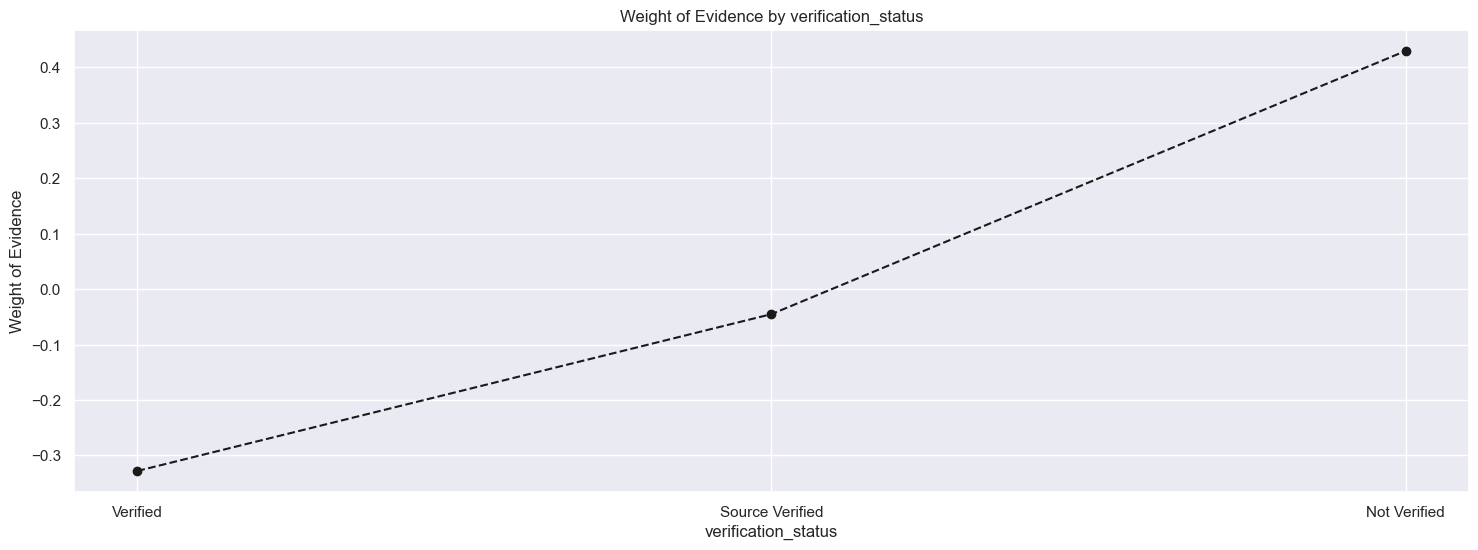

In [23]:
plot_by_woe(iv_per_var_dis["verification_status"][1])

In [24]:
data_in_use['verification_status:Verified_SourceVerified'] = sum([data_in_use['verification_status:Source Verified'],
                                                                              data_in_use['verification_status:Verified']])

#### Based on the WoE plot for the `verification_status` variable, it is evident that the reference category will be **`verification_status:Verified_SourceVerified`**, which represents the merged group combining the original "Verified" and "Source Verified" categories.

In [25]:
iv_per_var_dis["purpose"][1]

,purpose,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
3,educational,74,0.000164,53.0,21.0,0.000134,0.000369,0.716216,-1.013036,2.382483e-04
11,small_business,4928,0.010899,3968.0,960.0,0.010039,0.016881,0.805195,-0.519722,3.555972e-03
10,renewable_energy,294,0.000650,249.0,45.0,0.000630,0.000791,0.846939,-0.228016,3.678693e-05
8,moving,3040,0.006724,2581.0,459.0,0.006530,0.008071,0.849013,-0.211924,3.266565e-04
2,debt_consolidation,256217,0.566684,221324.0,34893.0,0.559938,0.613568,0.863815,-0.091465,4.905224e-03
7,medical,5506,0.012178,4777.0,729.0,0.012086,0.012819,0.867599,-0.058912,4.320423e-05
13,wedding,477,0.001055,414.0,63.0,0.001047,0.001108,0.867925,-0.056075,3.387512e-06
5,house,2835,0.006270,2476.0,359.0,0.006264,0.006313,0.873369,-0.007729,3.756351e-07
9,other,27778,0.061438,24314.0,3464.0,0.061513,0.060912,0.875297,0.009822,5.905562e-06
12,vacation,3037,0.006717,2678.0,359.0,0.006775,0.006313,0.881791,0.070697,3.269370e-05


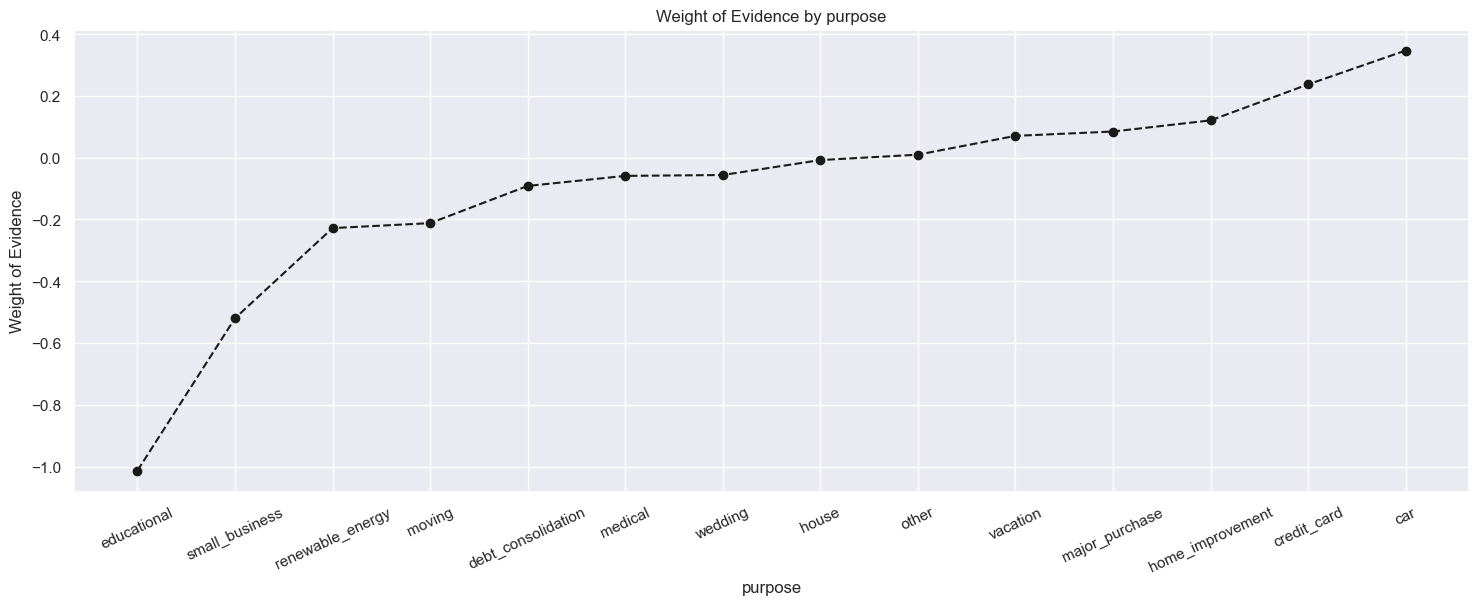

In [26]:
plot_by_woe(iv_per_var_dis["purpose"][1], rotation_of_x_axis_labels = 25) 

In [27]:
data_in_use['purpose:educational_small_business'] = sum([data_in_use['purpose:educational'],
                                                                    data_in_use['purpose:small_business']])


data_in_use['purpose:renewable_energy_moving'] = sum([data_in_use['purpose:renewable_energy'],
                                                                    data_in_use['purpose:moving']])


data_in_use['purpose:wedding_house_vacation'] = sum([data_in_use['purpose:wedding'],
                                                                data_in_use['purpose:house'],
                                                                data_in_use['purpose:vacation']])

### Insights from the WoE Table and Plot

- **Education** and **Small Business** can be merged into a single category due to their nearly identical WoE values. Additionally, *Education* has only 350 observations, making it too sparse to stand alone.

- **Renewable Energy** and **Moving** also exhibit similar WoE values. Given that *Renewable Energy* has just 1,151 records, merging it with *Moving* helps reduce category sparsity without sacrificing predictive performance.

- **Wedding**, **House**, and **Vacation** each account for a small proportion of the data and have similar WoE values. These can be grouped together into a single category to simplify the model.

- **Debt Consolidation** has over 1 million observations and is therefore retained as a **separate category**. Its dominant presence and moderate WoE justify treating it independently.

- **Medical**, **Other**, **Major Purchase**, **Home Improvement**, **Credit Card**, and **Car** have sufficient sample sizes and distinctive WoE values. These will be retained as **separate categories** in the model.

In [28]:
iv_per_var_dis["initial_list_status"][1]

,initial_list_status,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
0,f,145405,0.321597,122520.0,22885.0,0.309969,0.402416,0.842612,-0.261013,0.024130
1,w,306729,0.678403,272745.0,33984.0,0.690031,0.597584,0.889205,0.143841,0.013298


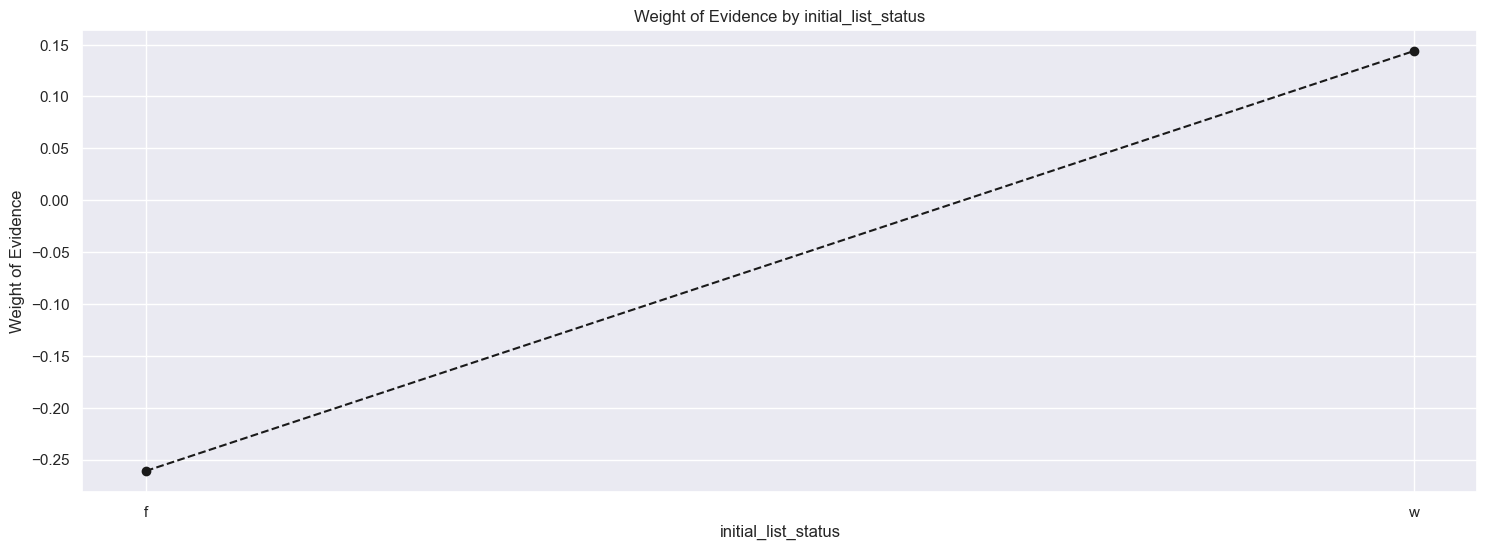

In [29]:
plot_by_woe(iv_per_var_dis["initial_list_status"][1]) 

### Reference Category Selection: `initial_list_status`

From the WoE table and plot, it is clear that both categories have a significant number of observations. However, the **probability of default (PD)** is noticeably higher for category **`f`** compared to category **`w`**.

Therefore, we will use **`initial_list_status:f`** as the **reference category** in the model.

In [30]:
iv_per_var_dis["term_int"][1]

,term_int,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
1,60,129742,0.286955,107568.0,22174.0,0.272141,0.389914,0.829092,-0.359603,0.042351
0,36,322392,0.713045,287697.0,34695.0,0.727859,0.610086,0.892383,0.176506,0.020788


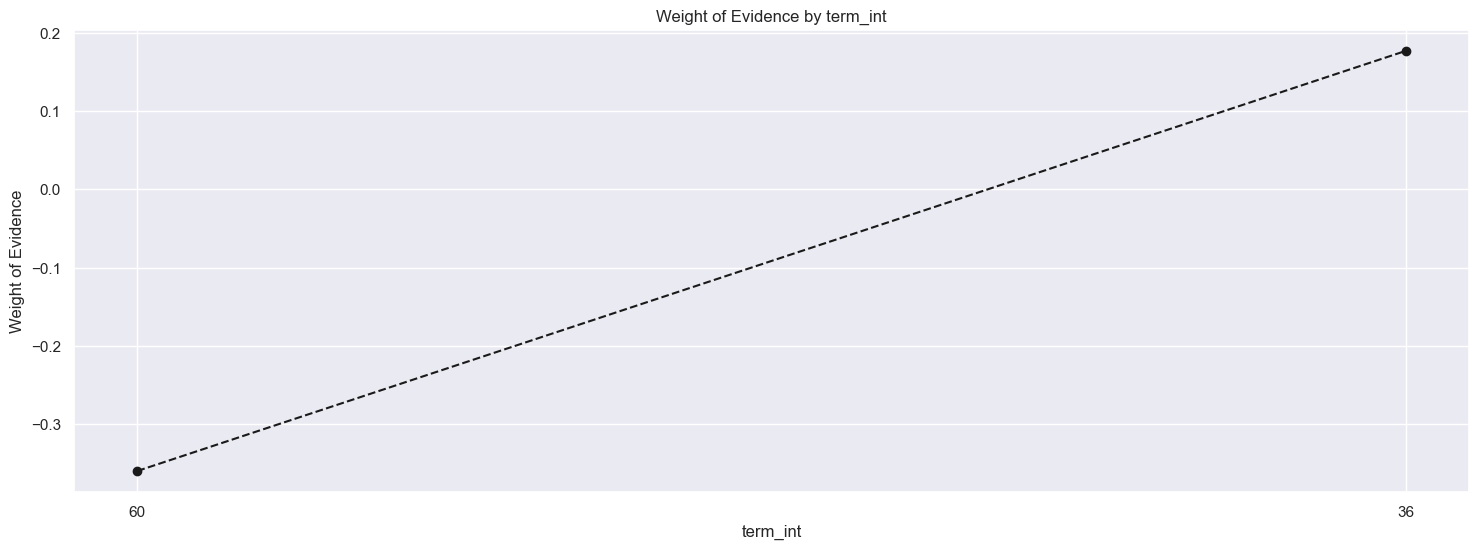

In [31]:
plot_by_woe(iv_per_var_dis["term_int"][1]) 

### From the WOE plot, it is clear that probability of default is much higher for loans with 60 month period and hence, 'term_int:60' will be our reference variable.

In [32]:
iv_per_var_dis["emp_length_int"][1]

,emp_length_int,n_obs,prop_obs,n_good,n_bad,prop_good_total,prop_bad_total,prop_good,WOE,IV
8,8,18509,0.040937,15948.0,2561.0,0.040348,0.045033,0.861635,-0.109870,5.148207e-04
0,0,67265,0.148772,58105.0,9160.0,0.147003,0.161072,0.863822,-0.091401,1.285941e-03
9,9,15849,0.035054,13752.0,2097.0,0.034792,0.036874,0.867689,-0.058130,1.210473e-04
1,1,29618,0.065507,25749.0,3869.0,0.065144,0.068034,0.869370,-0.043406,1.254405e-04
7,7,18538,0.041001,16141.0,2397.0,0.040836,0.042150,0.870698,-0.031661,4.159060e-05
3,3,36350,0.080397,31692.0,4658.0,0.080179,0.081908,0.871857,-0.021328,3.686367e-05
5,5,28054,0.062048,24476.0,3578.0,0.061923,0.062917,0.872460,-0.015917,1.581375e-05
2,2,40892,0.090442,35696.0,5196.0,0.090309,0.091368,0.872934,-0.011657,1.234247e-05
6,6,20486,0.045310,17911.0,2575.0,0.045314,0.045280,0.874304,0.000759,2.612664e-08
4,4,27183,0.060122,23897.0,3286.0,0.060458,0.057782,0.879116,0.045276,1.211697e-04


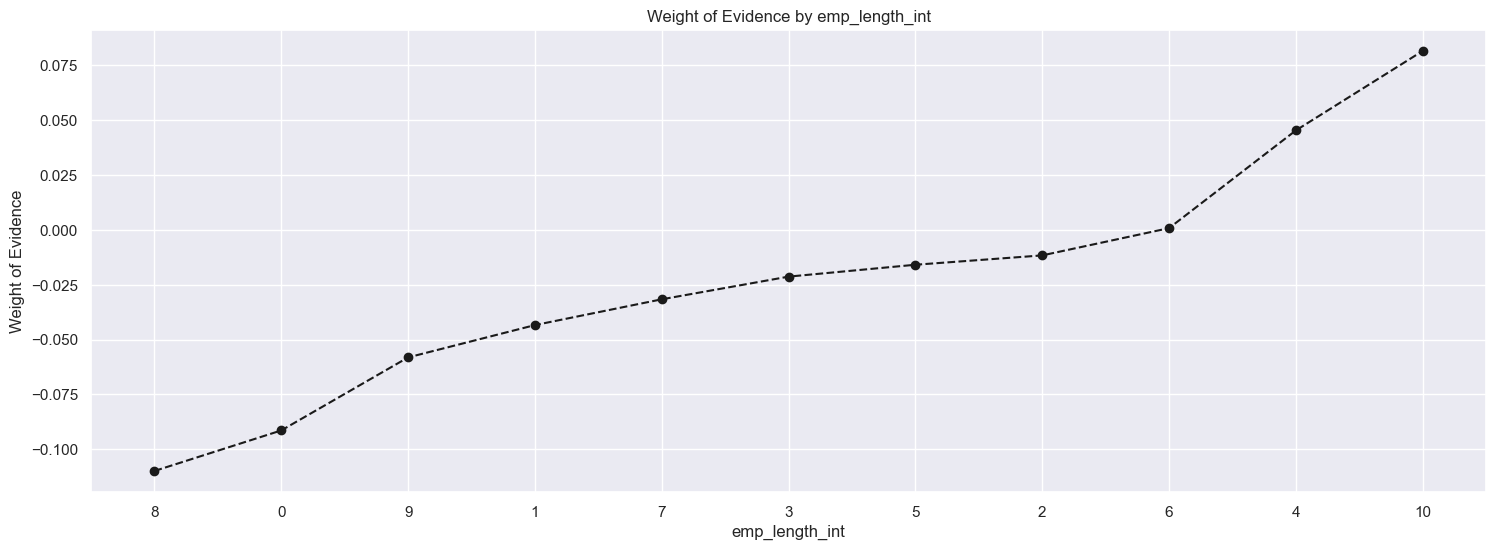

In [33]:
plot_by_woe(iv_per_var_dis["emp_length_int"][1])

### 📦 Binning Strategy for `emp_length_int`

Based on the Weight of Evidence (WOE) values and risk profiles, we group the `emp_length_int` variable into the following bins:

- **`0_8`**: This group combines categories `0` and `8`, both of which have relatively high default risk and similar WOE values (around –0.10). Merging them helps consolidate high-risk borrowers.

- **`1_7_9`**: Categories `1`, `7`, and `9` exhibit moderate and fairly close WOE values (ranging from –0.04 to –0.07). These represent mid-risk borrowers and can be safely grouped together.

- **`2_3_4_5_6`**: These categories have near-zero or slightly positive WOE values, indicating neutral or average risk. Grouping them simplifies the model without sacrificing predictive power.

- **`10`**: This category has the highest WOE (+0.078) and represents the lowest risk group. It is retained as a separate category to preserve its strong predictive signal.

- The newly created variable **`0_8`** will be the reference variable.

In [34]:
data_in_use['emp_length_int:2_3_4_5_6'] = sum([data_in_use['emp_length_int:2'],
                                                        data_in_use['emp_length_int:3'],
                                                        data_in_use['emp_length_int:4'],
                                                        data_in_use['emp_length_int:5'],
                                                        data_in_use['emp_length_int:6']])


data_in_use['emp_length_int:0_8'] = sum([data_in_use['emp_length_int:0'],
                                                    data_in_use['emp_length_int:8']])


data_in_use['emp_length_int:1_7_9'] = sum([data_in_use['emp_length_int:1'],
                                                    data_in_use['emp_length_int:7'],
                                                    data_in_use['emp_length_int:9']])

### **Saving data**

In [35]:
len(data_in_use.keys())

305

In [36]:
len(data_in_use)

452134

data_in_use.to_csv('dataset/train_input1.csv', index=False) # 305 columns and  1808534 rows

In [37]:
# Change the cell above to markdown before running this cell.
data_in_use.to_csv('dataset/test_input1.csv', index=False) # 305 columns and  452134 rows

### In order to test our model on the test data, we need to have the same dummy variables in our test_input dataset. To do that, we can just change the name of the datasets that we initialised earlier.

---

> **Training data**
>data_in_use = pd.read_csv('dataset/train_input.csv') # Loading updated data.
>>
>>output_data = pd.read_csv('dataset/train_output.csv') # Loading updated data.

> **Testing data**

>data_in_use = pd.read_csv('dataset/test_input.csv') # Loading updated data.
>>
>>output_data = pd.read_csv('dataset/test_output.csv') # Loading updated data.
>>
> **Saving data**
>> data_in_use.to_csv('dataset/train_input1.csv', index=False)
>>
>> data_in_use.to_csv('dataset/test_input1.csv', index=False)